In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [ ]:
SEQ_LEN = 30          # lookback window length
BATCH_SIZE = 64
HIDDEN_DIM = 64
NUM_LAYERS_SIMPLE = 1 
NUM_LAYERS_DEEP = 5     
NUM_EPOCHS = 30
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("data/SHEL_data.csv")

In [4]:

feature_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
values = df[feature_cols].astype(np.float32).values
n_samples, n_features = values.shape


In [5]:
split_idx = int(0.9 * n_samples)

In [6]:
scaler = StandardScaler()
values_train = values[:split_idx]
scaler.fit(values_train)
values_scaled = scaler.transform(values).astype(np.float32)

In [7]:
def make_sequences(values_scaled, seq_len, split_idx):
    X_train, y_train = [], []
    X_test, y_test = [], []

    # training sequences: target index t in [seq_len, split_idx-1]
    for t in range(seq_len, split_idx):
        X_train.append(values_scaled[t-seq_len:t])
        y_train.append(values_scaled[t])

    # test sequences: target index t in [split_idx, n_samples-1]
    n_total = values_scaled.shape[0]
    for t in range(split_idx, n_total):
        if t - seq_len < 0:
            continue
        X_test.append(values_scaled[t-seq_len:t])
        y_test.append(values_scaled[t])

    X_train = np.stack(X_train)  # [N_train, T, D]
    y_train = np.stack(y_train)  # [N_train, D]
    X_test = np.stack(X_test)    # [N_test, T, D]
    y_test = np.stack(y_test)    # [N_test, D]

    return X_train, y_train, X_test, y_test


In [8]:

X_train, y_train, X_test, y_test = make_sequences(values_scaled, SEQ_LEN, split_idx)

In [9]:
print("Train sequences:", X_train.shape, "Test sequences:", X_test.shape)

Train sequences: (849, 30, 6) Test sequences: (98, 30, 6)


In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # [N, T, D]
        self.y = torch.from_numpy(y)  # [N, D]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
train_ds = TimeSeriesDataset(X_train, y_train)
test_ds = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
class RNNForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,
                 rnn_type="LSTM", num_layers=1):
        super().__init__()
        if rnn_type == "RNN":
            self.rnn = nn.RNN(
                input_dim, hidden_dim, num_layers=num_layers,
                batch_first=True
            )
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(
                input_dim, hidden_dim, num_layers=num_layers,
                batch_first=True
            )
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(
                input_dim, hidden_dim, num_layers=num_layers,
                batch_first=True
            )
        else:
            raise ValueError("rnn_type must be 'RNN', 'GRU', or 'LSTM'")
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [B, T, D]
        out, _ = self.rnn(x)      # out: [B, T, H]
        last_hidden = out[:, -1]  # [B, H]
        pred = self.fc(last_hidden)  # [B, D]
        return pred


In [13]:
def make_model(model_name="Simple LSTM"):
    if "RNN" in model_name and "Simple" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="RNN", num_layers=NUM_LAYERS_SIMPLE)
    if "RNN" in model_name and "Deep" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="RNN", num_layers=NUM_LAYERS_DEEP)
    if "GRU" in model_name and "Simple" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="GRU", num_layers=NUM_LAYERS_SIMPLE)
    if "GRU" in model_name and "Deep" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="GRU", num_layers=NUM_LAYERS_DEEP)
    if "LSTM" in model_name and "Simple" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="LSTM", num_layers=NUM_LAYERS_SIMPLE)
    if "LSTM" in model_name and "Deep" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="LSTM", num_layers=NUM_LAYERS_DEEP)
    # default
    return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                         rnn_type="LSTM", num_layers=NUM_LAYERS_SIMPLE)

In [14]:
def train_model(model_name="Simple LSTM"):
    model = make_model(model_name).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_ds)
        if epoch % 5 == 0 or epoch == 1:
            print(f"[{model_name}] Epoch {epoch}/{NUM_EPOCHS}, "
                  f"Train MSE (scaled): {train_loss:.4f}")

    return model

In [ ]:
def compute_metrics(y_true_scaled, y_pred_scaled, X_test_scaled_last):
    
    mse_scaled = np.mean((y_pred_scaled - y_true_scaled) ** 2)
    rmse_scaled = np.sqrt(mse_scaled)

    # MAPE on original scale
    y_true = scaler.inverse_transform(y_true_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    eps = 1e-6
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0

    # MDA -- direction of change from last input to target
    # using scaled values. The sign is preserved
    last = X_test_scaled_last
    actual_change = np.sign(y_true_scaled - last)
    pred_change = np.sign(y_pred_scaled - last)
    correct_dir = (actual_change == pred_change).astype(np.float32)
    mda = correct_dir.mean()

    # R^2 on scaled
    r2 = r2_score(
        y_true_scaled.reshape(-1),
        y_pred_scaled.reshape(-1)
    )

    # Forecast bias (on original)
    bias_per_feature = np.mean(y_pred - y_true, axis=0)  # [D]
    bias_overall = bias_per_feature.mean()
    # classify as over / under / none
    avg_abs_level = np.mean(np.abs(y_true))
    threshold = 0.01 * avg_abs_level  # 1% of average magnitude
    if abs(bias_overall) < threshold:
        bias_flag = "None / minimal"
    elif bias_overall > 0:
        bias_flag = "Over-forecast (too high)"
    else:
        bias_flag = "Under-forecast (too low)"

    metrics = {
        "Scaled_RMSE": float(rmse_scaled),
        "MAPE_percent": float(mape),
        "MDA": float(mda),
        "R2": float(r2),
        "Bias_overall": float(bias_overall),
        "Bias_flag": bias_flag,
        "Bias_per_feature": dict(zip(feature_cols, bias_per_feature))
    }
    return metrics

**SIMPLE LSTM**

In [ ]:
model_name = "Simple LSTM"  
model = train_model(model_name)


[Simple LSTM] Epoch 1/30, Train MSE (scaled): 0.8458
[Simple LSTM] Epoch 5/30, Train MSE (scaled): 0.1734
[Simple LSTM] Epoch 10/30, Train MSE (scaled): 0.1500
[Simple LSTM] Epoch 15/30, Train MSE (scaled): 0.1438
[Simple LSTM] Epoch 20/30, Train MSE (scaled): 0.1411
[Simple LSTM] Epoch 25/30, Train MSE (scaled): 0.1382
[Simple LSTM] Epoch 30/30, Train MSE (scaled): 0.1368


In [17]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [ ]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)   # [N_test, D]
y_true_scaled = np.concatenate(all_true_scaled, axis=0)    # same as above
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)  # same as above

In [19]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Simple LSTM ===
Scaled_RMSE : 0.4236878752708435
MAPE_percent : 6.328971862792969
MDA : 0.5374149680137634
R2 : 0.7906031012535095
Bias_overall : 16898.73046875
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.4385
  High: 0.0593
  Low: 0.1121
  Close: 0.1333
  Adj Close: -0.7694
  Volume: 101392.4062


In [20]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Simple LSTM', 'Scaled RMSE': 0.4236878752708435, 'MAPE': 6.328971862792969, 'Mean Directional Accuracy (MDA)': 0.5374149680137634, 'R^2': 0.7906031012535095, 'Forecast Bias?': 'Over-forecast (too high)'}


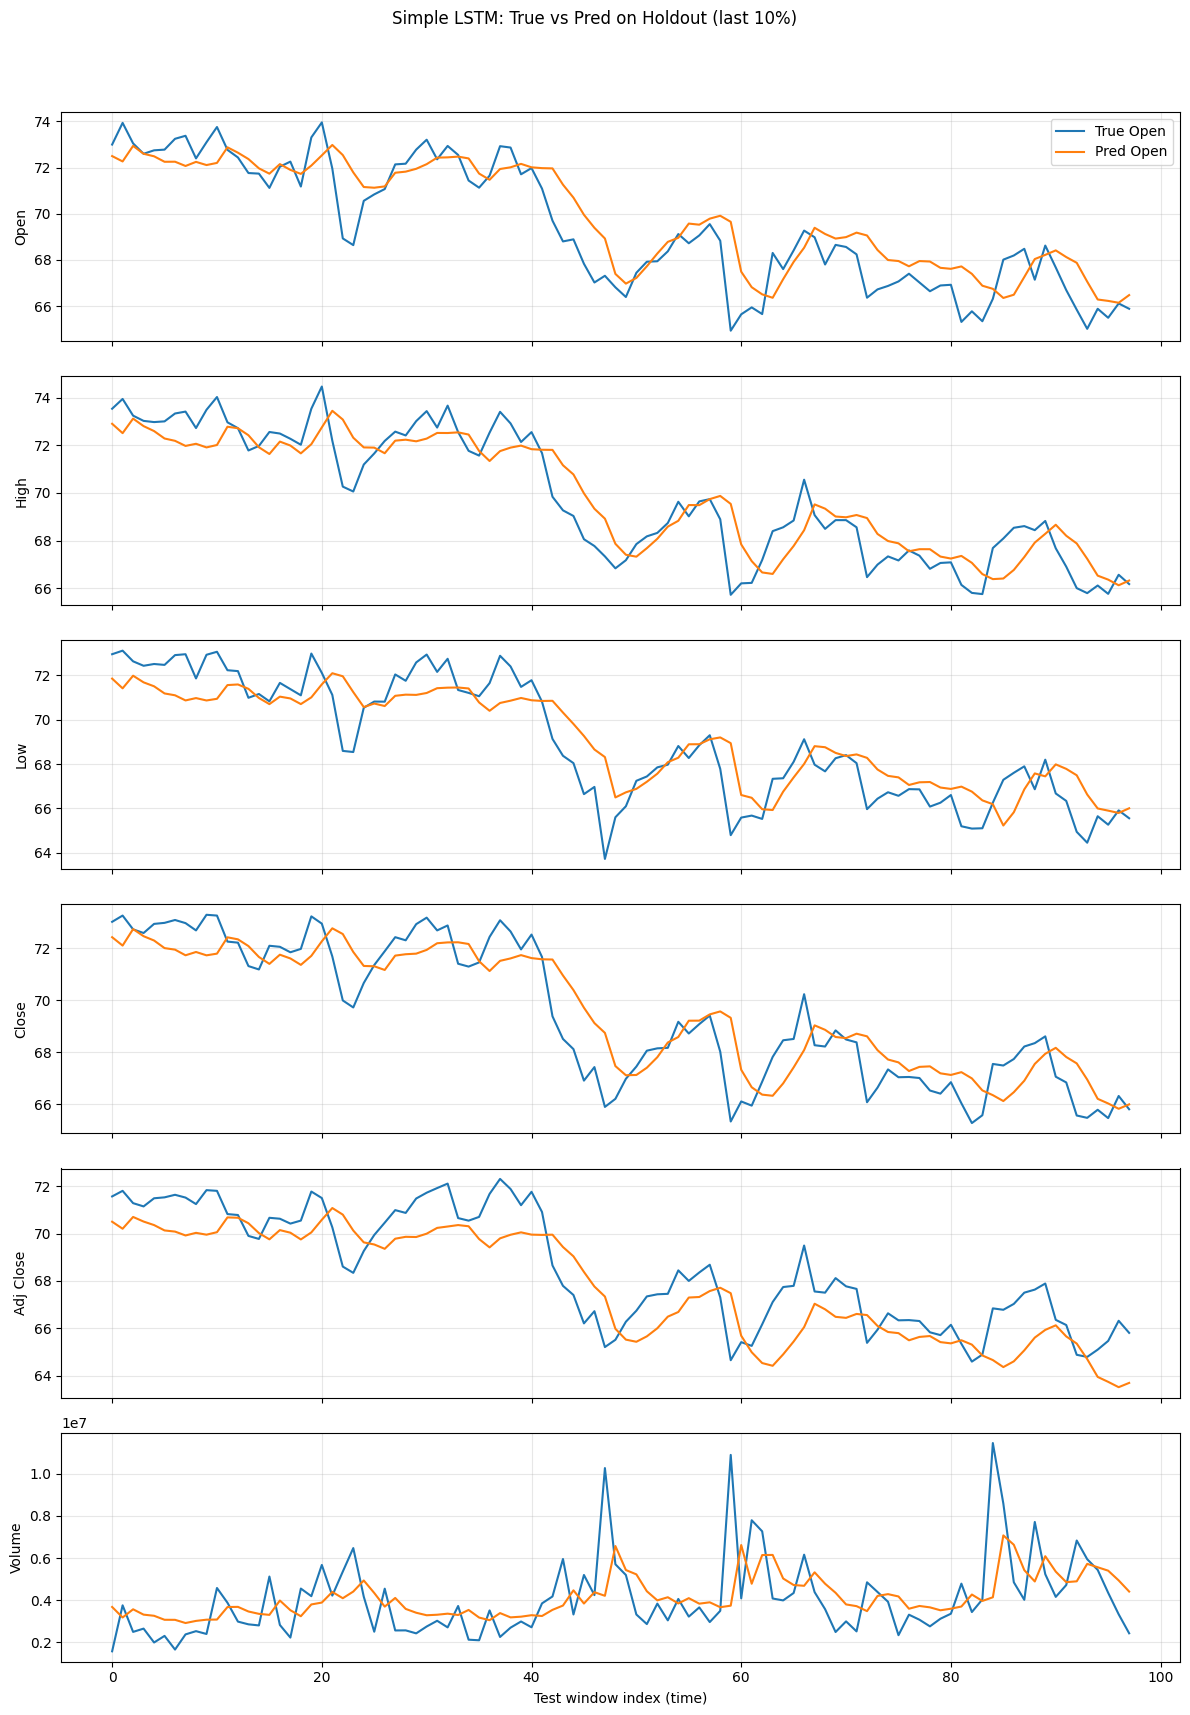

In [21]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**DEEP LSTM**

In [ ]:
model_name = "Deep LSTM"  
model = train_model(model_name)


[Deep LSTM] Epoch 1/30, Train MSE (scaled): 0.8878
[Deep LSTM] Epoch 5/30, Train MSE (scaled): 0.1913
[Deep LSTM] Epoch 10/30, Train MSE (scaled): 0.1781
[Deep LSTM] Epoch 15/30, Train MSE (scaled): 0.1683
[Deep LSTM] Epoch 20/30, Train MSE (scaled): 0.1588
[Deep LSTM] Epoch 25/30, Train MSE (scaled): 0.1513
[Deep LSTM] Epoch 30/30, Train MSE (scaled): 0.1441


In [23]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [ ]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)   # [N_test, D]
y_true_scaled = np.concatenate(all_true_scaled, axis=0)    # same as above
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)  # same as above

In [25]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Deep LSTM ===
Scaled_RMSE : 0.44763675332069397
MAPE_percent : 7.27622652053833
MDA : 0.5408163070678711
R2 : 0.7662618160247803
Bias_overall : 27504.390625
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 1.0208
  High: 0.9232
  Low: 0.9923
  Close: 0.8225
  Adj Close: -0.3395
  Volume: 165022.9219


In [26]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Deep LSTM', 'Scaled RMSE': 0.44763675332069397, 'MAPE': 7.27622652053833, 'Mean Directional Accuracy (MDA)': 0.5408163070678711, 'R^2': 0.7662618160247803, 'Forecast Bias?': 'Over-forecast (too high)'}


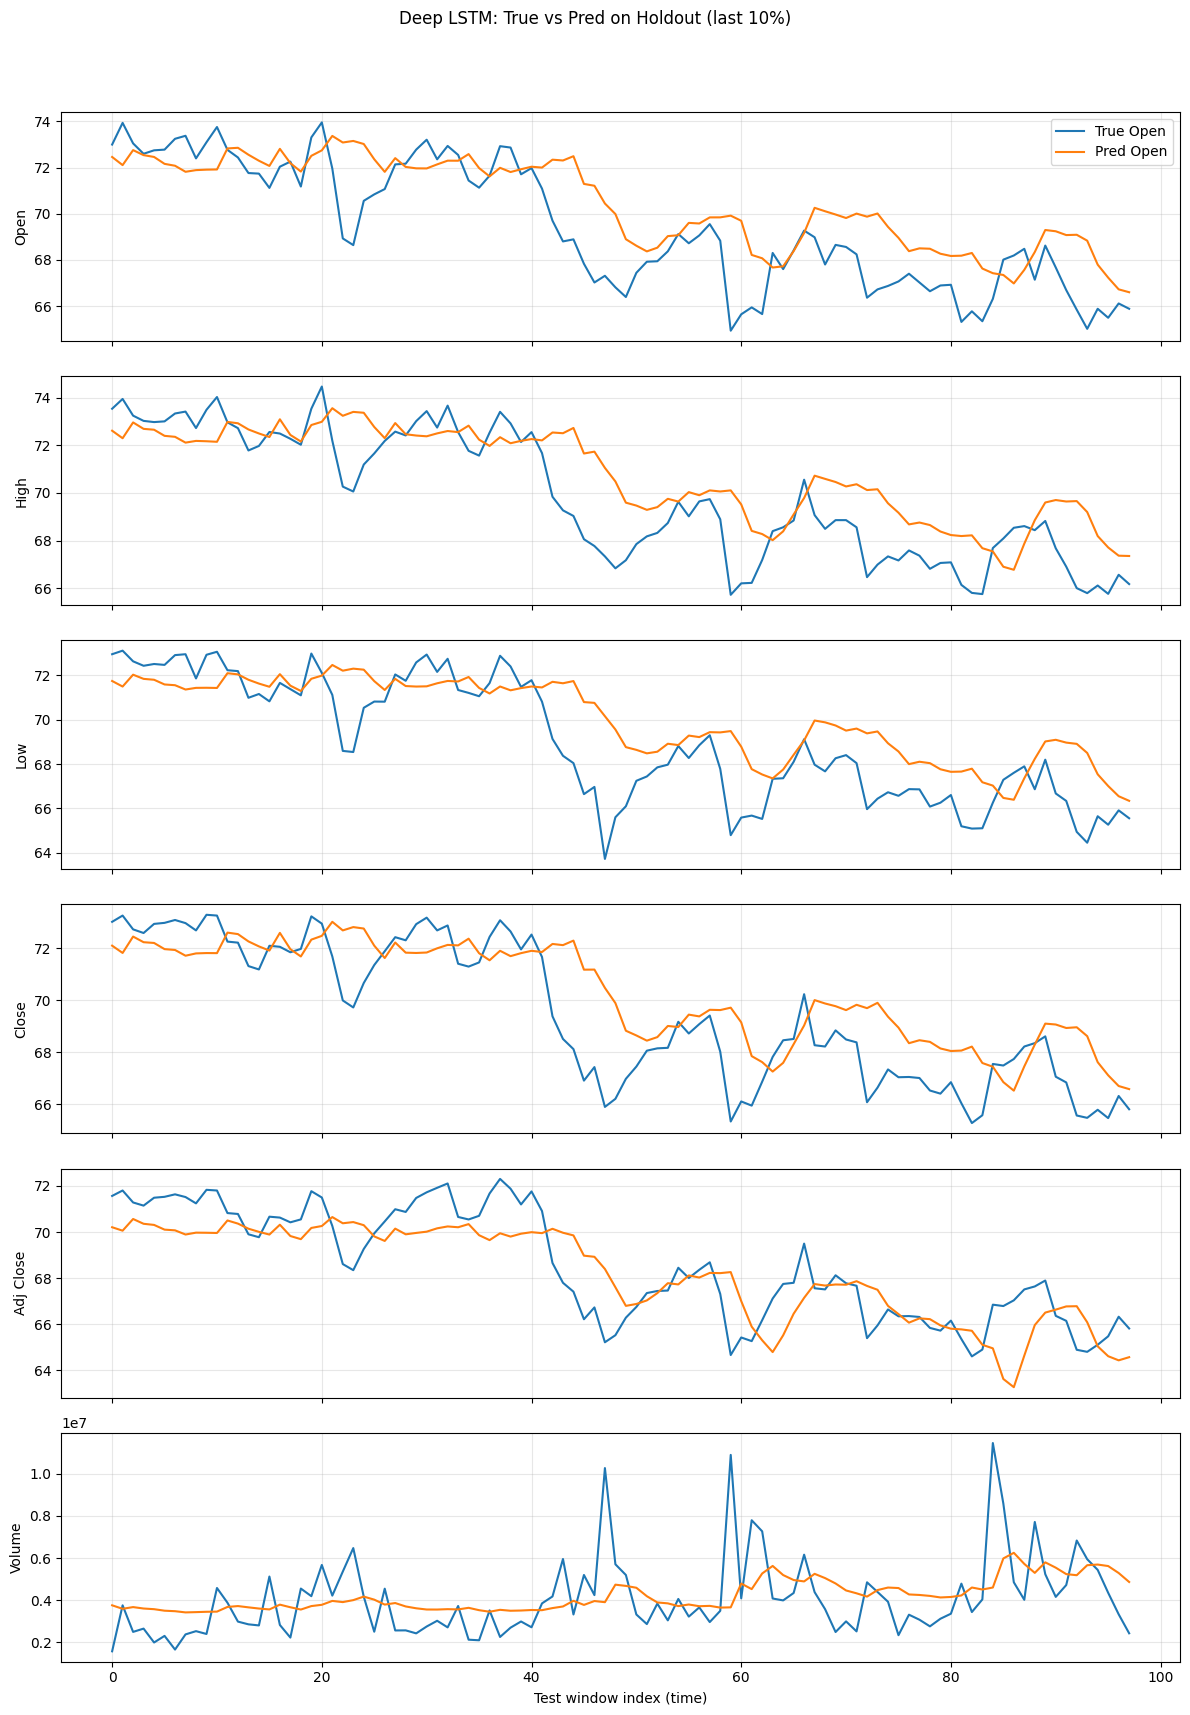

In [27]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**SIMPLE RNN**

In [ ]:
model_name = "Simple RNN" 
model = train_model(model_name)


[Simple RNN] Epoch 1/30, Train MSE (scaled): 0.6236
[Simple RNN] Epoch 5/30, Train MSE (scaled): 0.1504
[Simple RNN] Epoch 10/30, Train MSE (scaled): 0.1405
[Simple RNN] Epoch 15/30, Train MSE (scaled): 0.1389
[Simple RNN] Epoch 20/30, Train MSE (scaled): 0.1375
[Simple RNN] Epoch 25/30, Train MSE (scaled): 0.1364
[Simple RNN] Epoch 30/30, Train MSE (scaled): 0.1370


In [29]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [ ]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)  
y_true_scaled = np.concatenate(all_true_scaled, axis=0)   
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)

In [31]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Simple RNN ===
Scaled_RMSE : 0.422627329826355
MAPE_percent : 6.3404998779296875
MDA : 0.523809552192688
R2 : 0.7916500568389893
Bias_overall : 17391.919921875
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: -0.0947
  High: -0.1030
  Low: -0.0359
  Close: -0.2885
  Adj Close: -1.5667
  Volume: 104353.6016


In [32]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Simple RNN', 'Scaled RMSE': 0.422627329826355, 'MAPE': 6.3404998779296875, 'Mean Directional Accuracy (MDA)': 0.523809552192688, 'R^2': 0.7916500568389893, 'Forecast Bias?': 'Over-forecast (too high)'}


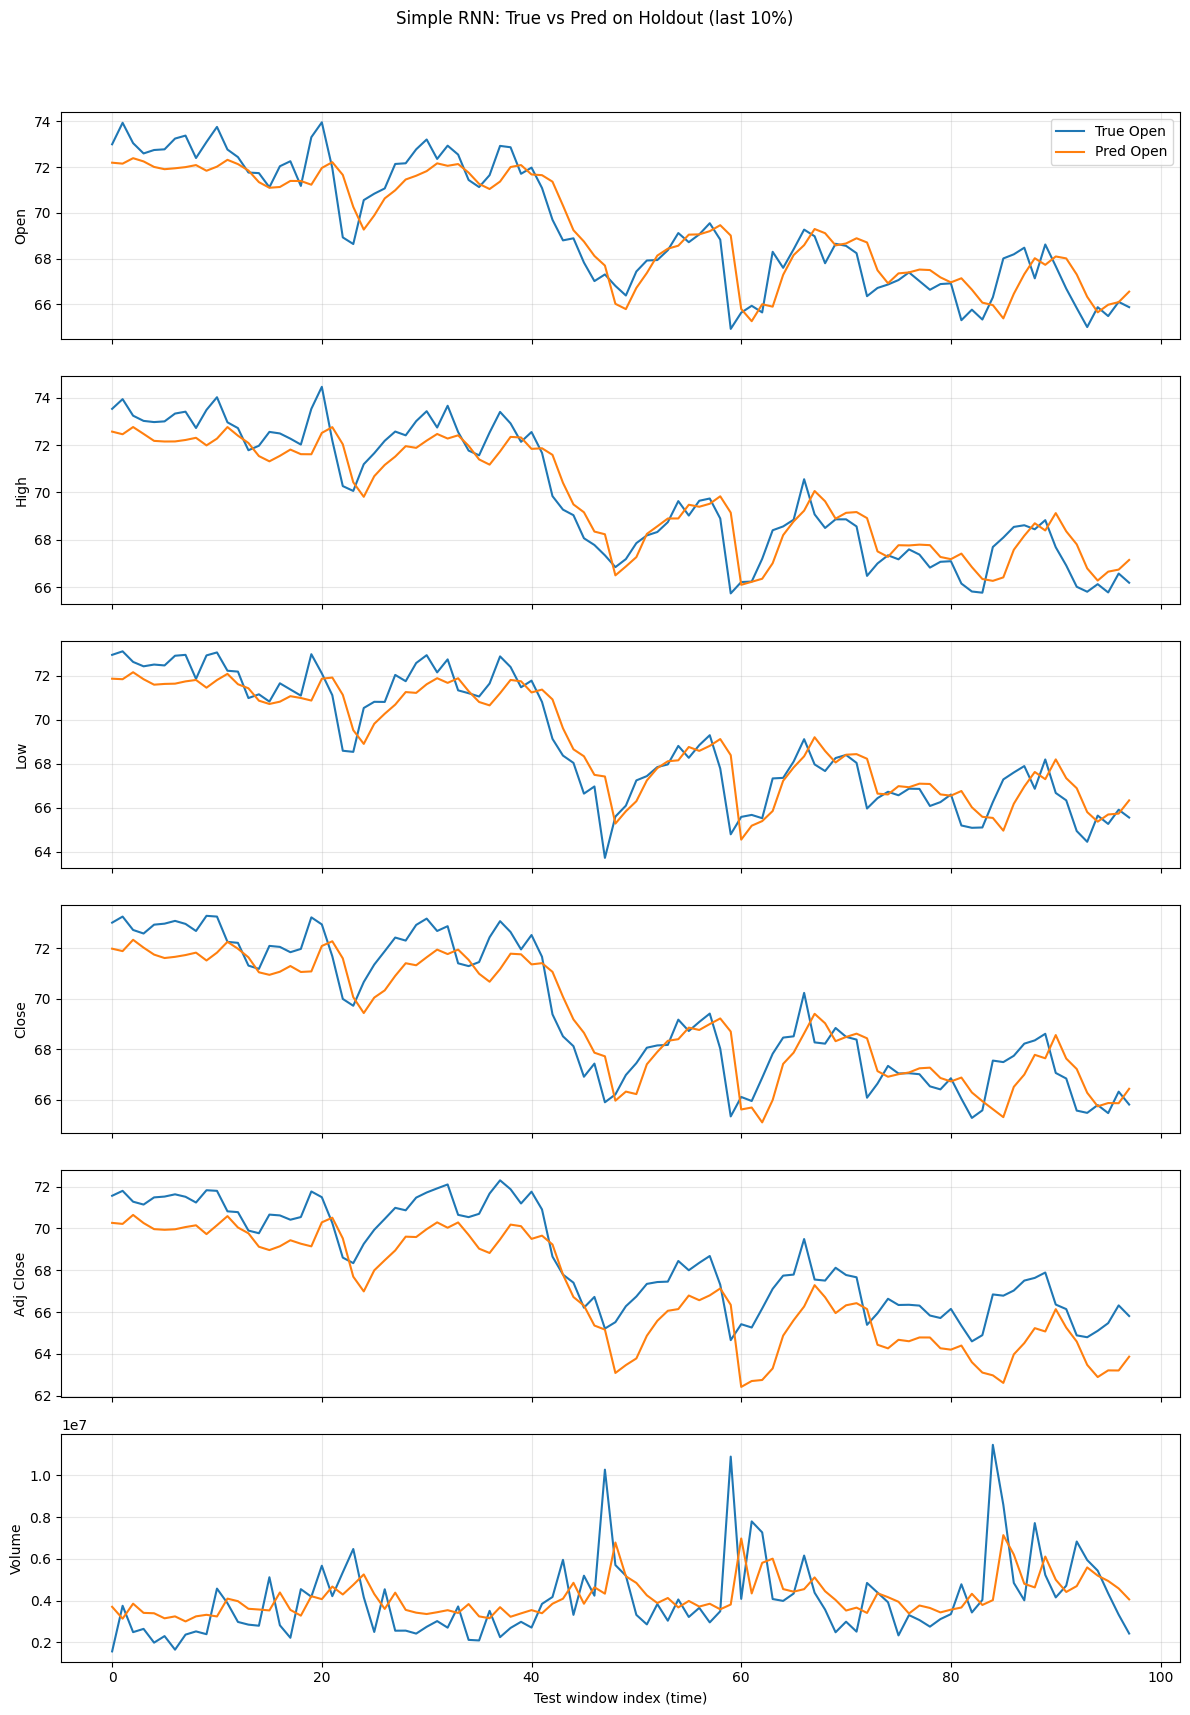

In [33]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**DEEP RNN**

In [ ]:
model_name = "Deep RNN"   
model = train_model(model_name)


[Deep RNN] Epoch 1/30, Train MSE (scaled): 0.5385
[Deep RNN] Epoch 5/30, Train MSE (scaled): 0.1698
[Deep RNN] Epoch 10/30, Train MSE (scaled): 0.1447
[Deep RNN] Epoch 15/30, Train MSE (scaled): 0.1458
[Deep RNN] Epoch 20/30, Train MSE (scaled): 0.1395
[Deep RNN] Epoch 25/30, Train MSE (scaled): 0.1398
[Deep RNN] Epoch 30/30, Train MSE (scaled): 0.1360


In [54]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [55]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)   # [N_test, D]
y_true_scaled = np.concatenate(all_true_scaled, axis=0)    # [N_test, D]
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)  # [N_test, D]

In [56]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Deep RNN ===
Scaled_RMSE : 0.4266117513179779
MAPE_percent : 6.190854072570801
MDA : 0.5765306353569031
R2 : 0.7877030372619629
Bias_overall : -7762.49072265625
Bias_flag : Under-forecast (too low)
Bias_per_feature :
  Open: 0.1644
  High: -0.1319
  Low: 0.0677
  Close: -0.1465
  Adj Close: -0.9477
  Volume: -46573.9531


In [57]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Deep RNN', 'Scaled RMSE': 0.4266117513179779, 'MAPE': 6.190854072570801, 'Mean Directional Accuracy (MDA)': 0.5765306353569031, 'R^2': 0.7877030372619629, 'Forecast Bias?': 'Under-forecast (too low)'}


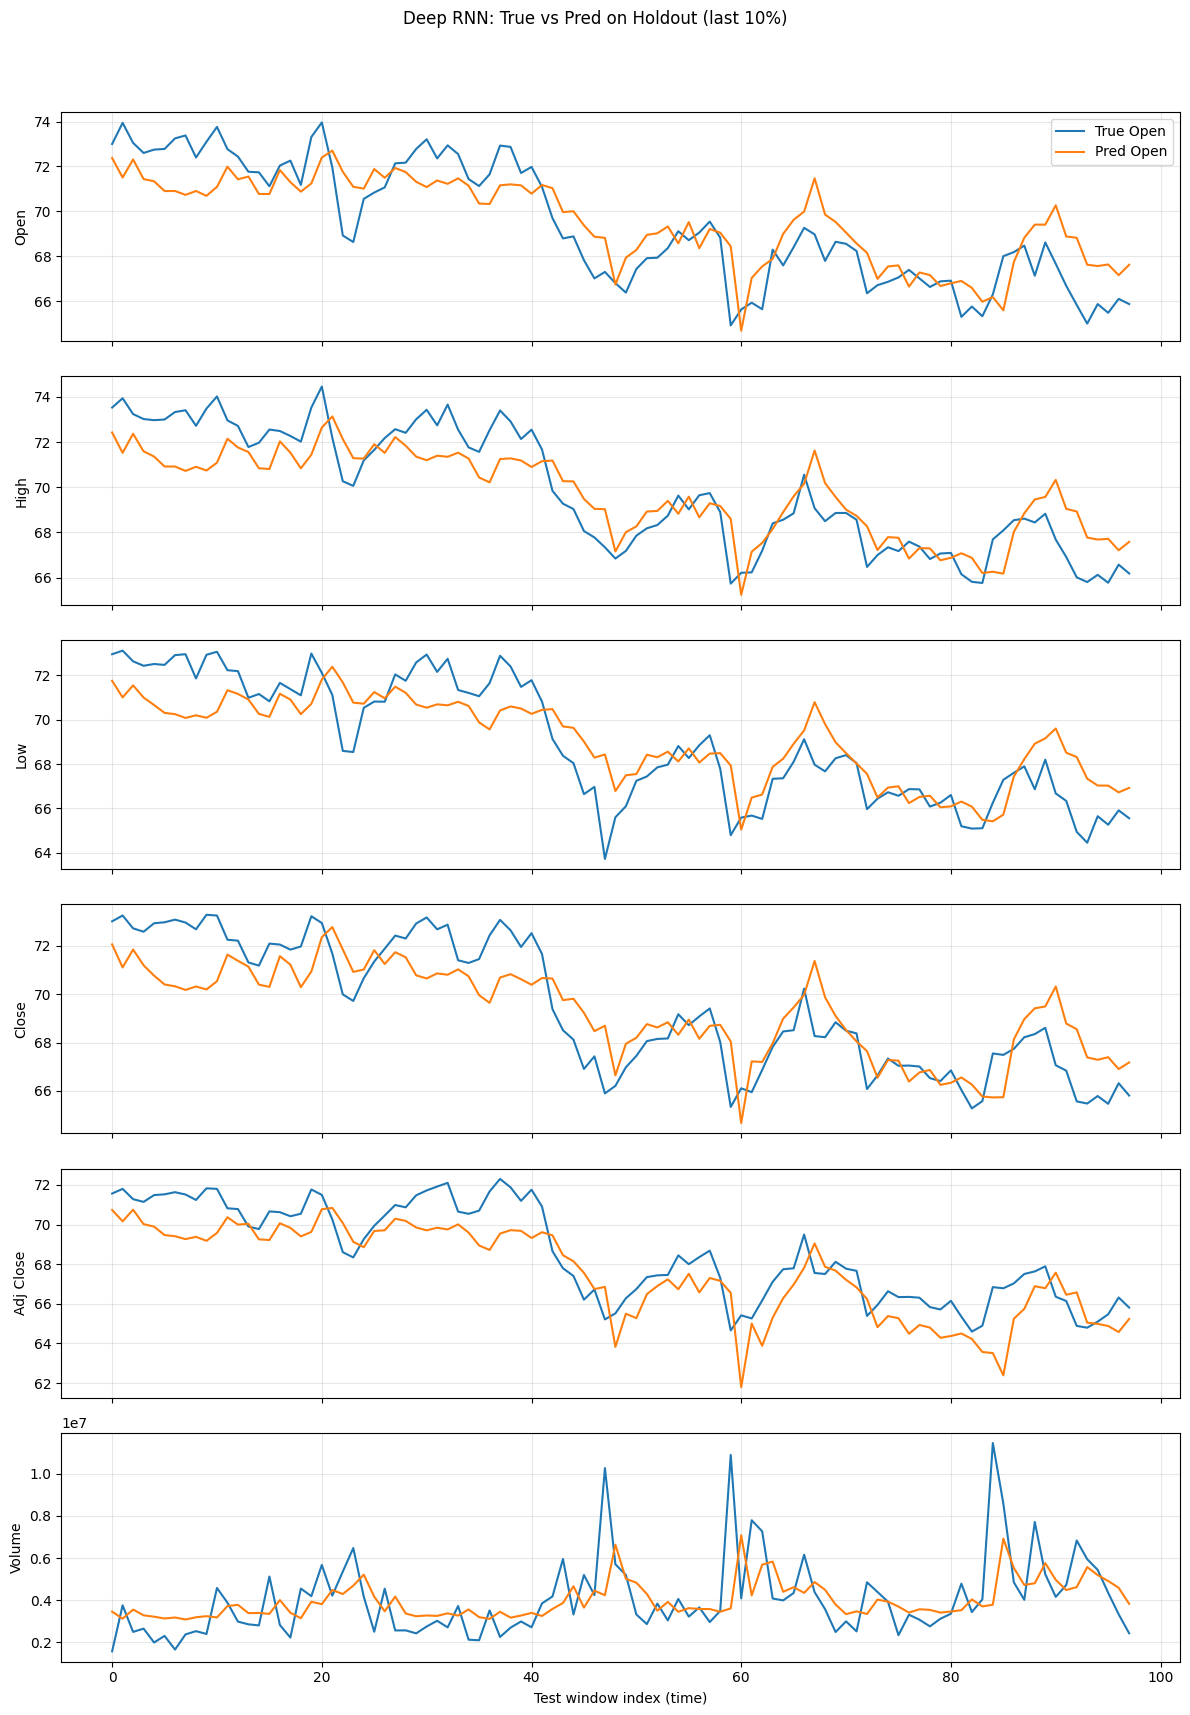

In [58]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**SIMPLE GRU**

In [ ]:
model_name = "Simple GRU" 
model = train_model(model_name)


[Simple GRU] Epoch 1/30, Train MSE (scaled): 0.8009
[Simple GRU] Epoch 5/30, Train MSE (scaled): 0.1619


[Simple GRU] Epoch 10/30, Train MSE (scaled): 0.1446
[Simple GRU] Epoch 15/30, Train MSE (scaled): 0.1399
[Simple GRU] Epoch 20/30, Train MSE (scaled): 0.1377
[Simple GRU] Epoch 25/30, Train MSE (scaled): 0.1366
[Simple GRU] Epoch 30/30, Train MSE (scaled): 0.1360


In [41]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [ ]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)  
y_true_scaled = np.concatenate(all_true_scaled, axis=0)   
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0) 

In [43]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Simple GRU ===
Scaled_RMSE : 0.42184704542160034
MAPE_percent : 6.362511157989502
MDA : 0.5017006993293762
R2 : 0.7924187183380127
Bias_overall : 26636.140625
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.3127
  High: 0.1838
  Low: 0.3246
  Close: 0.0260
  Adj Close: -0.6182
  Volume: 159816.6094


In [44]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Simple GRU', 'Scaled RMSE': 0.42184704542160034, 'MAPE': 6.362511157989502, 'Mean Directional Accuracy (MDA)': 0.5017006993293762, 'R^2': 0.7924187183380127, 'Forecast Bias?': 'Over-forecast (too high)'}


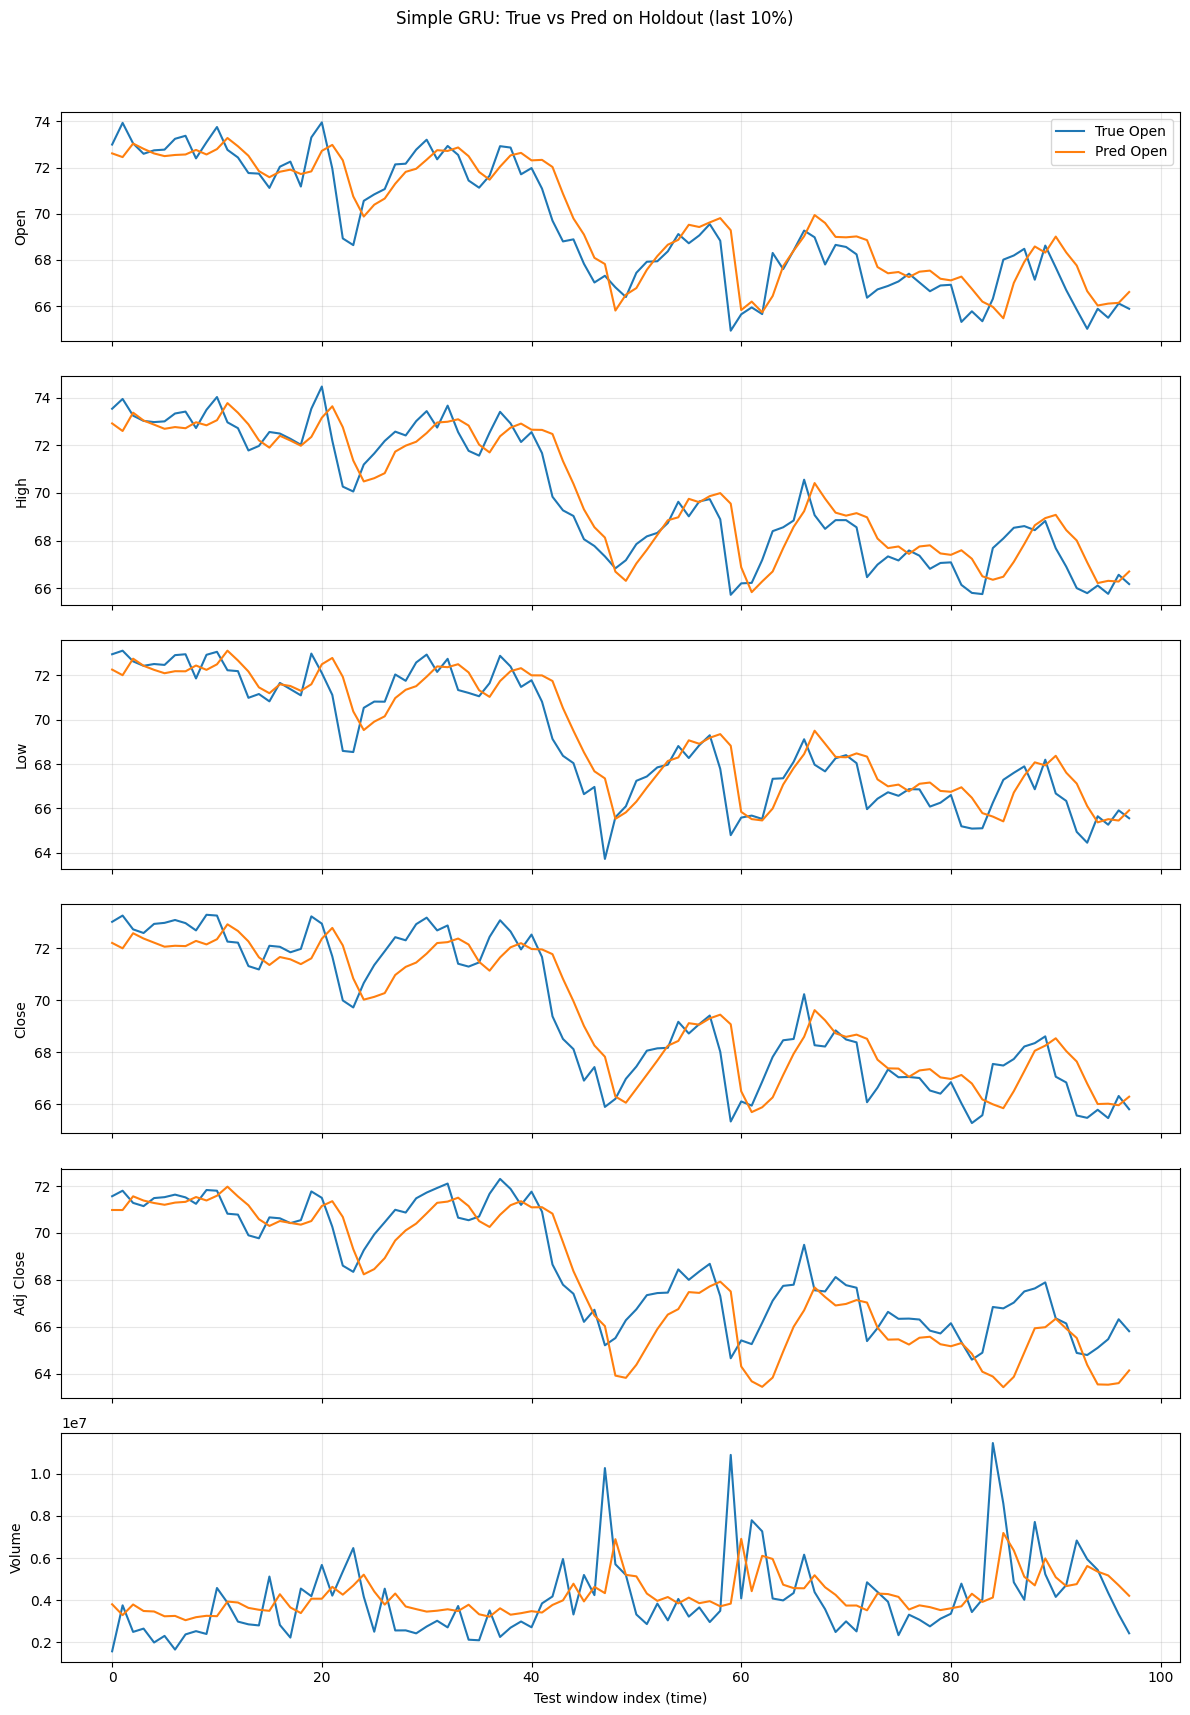

In [45]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**DEEP GRU**

In [ ]:
model_name = "Deep GRU" 
model = train_model(model_name)


[Deep GRU] Epoch 1/30, Train MSE (scaled): 0.5741
[Deep GRU] Epoch 5/30, Train MSE (scaled): 0.1775


[Deep GRU] Epoch 10/30, Train MSE (scaled): 0.1469
[Deep GRU] Epoch 15/30, Train MSE (scaled): 0.1384
[Deep GRU] Epoch 20/30, Train MSE (scaled): 0.1370
[Deep GRU] Epoch 25/30, Train MSE (scaled): 0.1354
[Deep GRU] Epoch 30/30, Train MSE (scaled): 0.1352


In [47]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [ ]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)   
y_true_scaled = np.concatenate(all_true_scaled, axis=0)    
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)  

In [49]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Deep GRU ===
Scaled_RMSE : 0.4201190173625946
MAPE_percent : 5.813717842102051
MDA : 0.5221088528633118
R2 : 0.7941159009933472
Bias_overall : -7081.40087890625
Bias_flag : Under-forecast (too low)
Bias_per_feature :
  Open: 0.1663
  High: 0.1092
  Low: 0.2031
  Close: 0.1362
  Adj Close: -0.7090
  Volume: -42488.3125


In [50]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Deep GRU', 'Scaled RMSE': 0.4201190173625946, 'MAPE': 5.813717842102051, 'Mean Directional Accuracy (MDA)': 0.5221088528633118, 'R^2': 0.7941159009933472, 'Forecast Bias?': 'Under-forecast (too low)'}


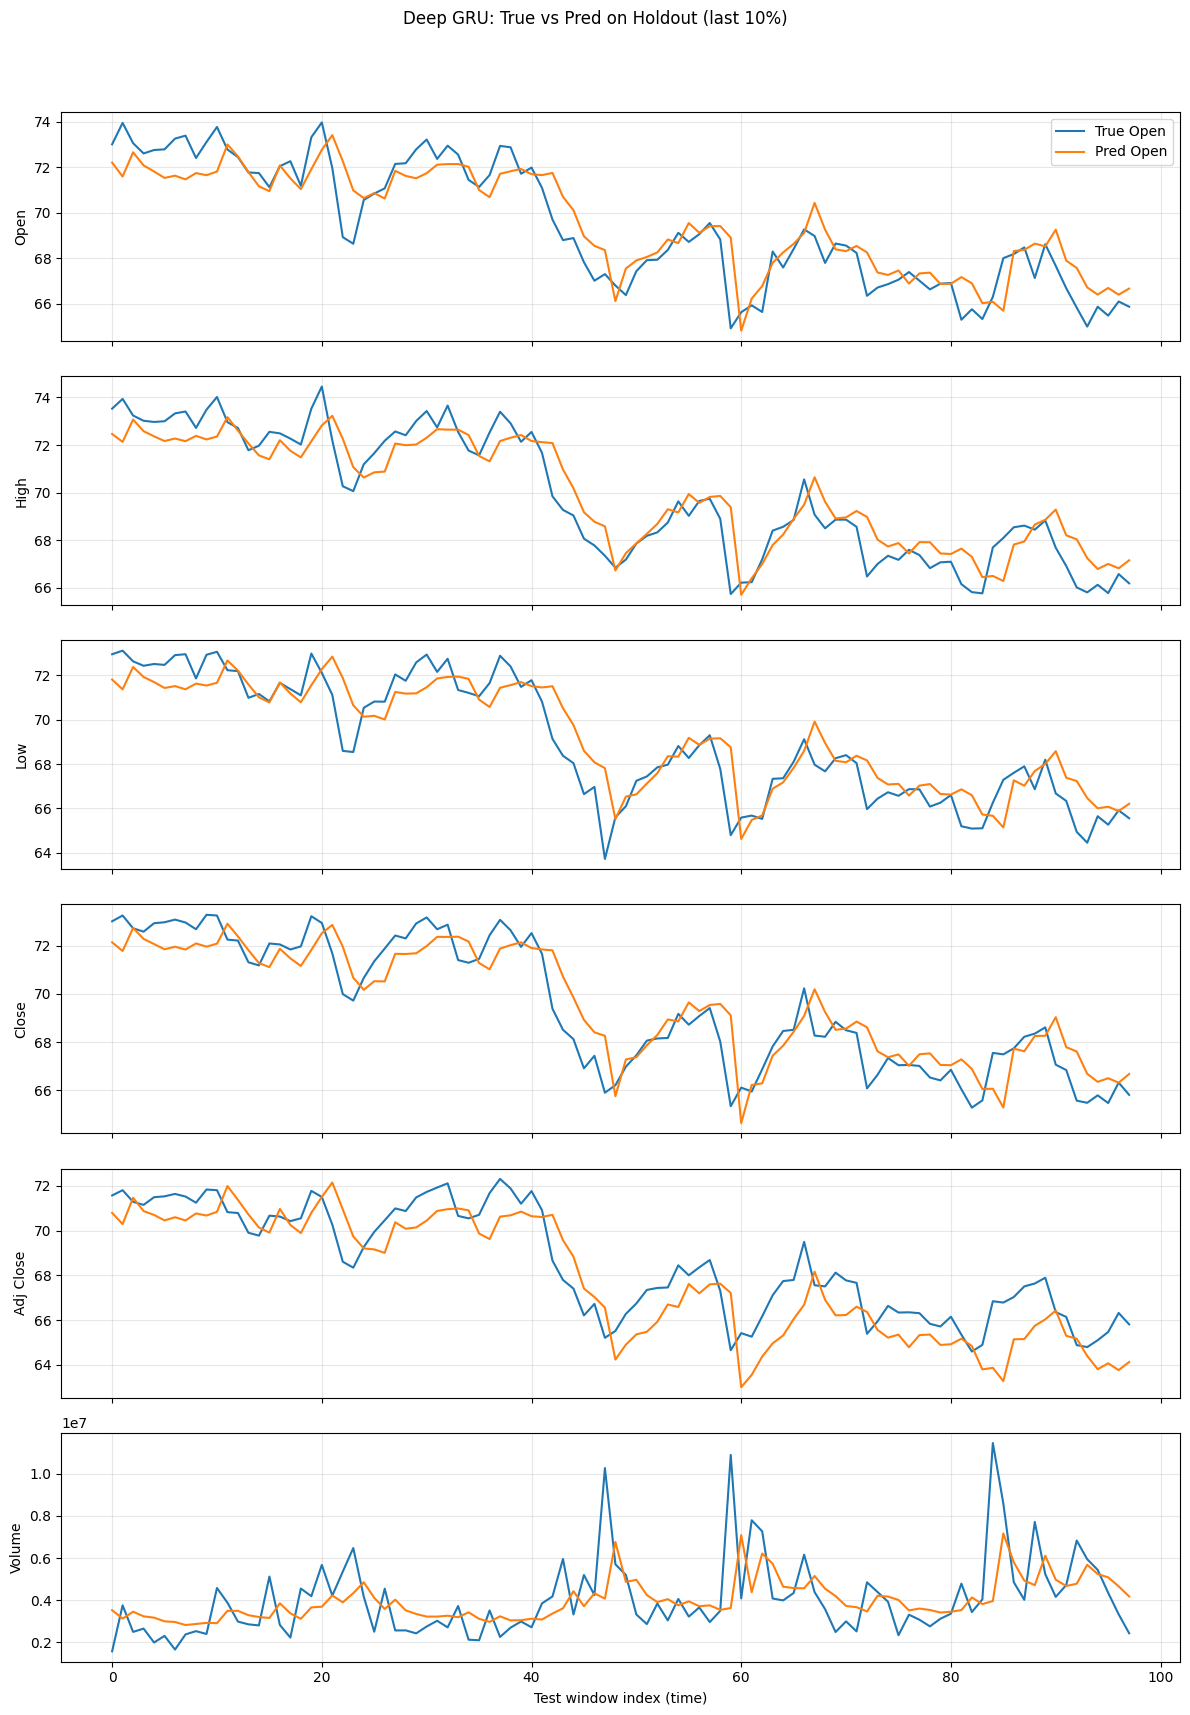

In [51]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()